In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import laplace
import random
from matplotlib.font_manager import FontProperties


In [5]:
def plot_tumor_growth(info, grid_size, tumors, title, color_bar=True):
    plt.figure(figsize=(7, 7))  # Create a new figure for each plot
    plt.imshow(info, cmap='Wistia')
    plt.title(title, fontsize=13, fontweight='bold')
    if color_bar:
        cbar = plt.colorbar(shrink=0.8)  # Make the colorbar 80% of its original height
        cbar.set_label('Resistance of Voxels', fontsize=13, fontweight='bold', labelpad=10)
        cbar.set_ticks([v for v in np.arange(0, 1.01, 0.2)])
        font = FontProperties()
        font.set_size(13)
        for label in cbar.ax.get_xticklabels():
            label.set_fontproperties(font)
        cbar.ax.tick_params(labelsize=13)

    y_coords, x_coords = np.where(tumors == 1)
    plt.scatter(x_coords, y_coords, color='black', label="Cancerous Voxel", marker='o', s=3)
    plt.xticks(np.arange(0, grid_size+1, 20))
    plt.yticks(np.arange(0, grid_size+1, 20))
    plt.tick_params(axis='both', which='major', labelsize=13) # You can adjust the labelsize value
    plt.gca().invert_yaxis() # Add this line
    plt.legend()
    # plt.savefig("my_plot.pdf", format="pdf", bbox_inches="tight")
    plt.show()

def plot_oxygen_diffusion(info, grid_size, tumors, title, tumor_flag=True):
    plt.figure(figsize=(7, 7))  # Create a new figure for each plot
    plt.imshow(info, cmap='Blues')
    plt.title(title, fontsize=13, fontweight='bold', pad=15)

    cbar = plt.colorbar(shrink=0.8)  # Make the colorbar 80% of its original height
    cbar.set_label('Oxygen Levels in Voxels', fontsize=13, fontweight='bold', labelpad=10)

    font = FontProperties()
    font.set_size(13)
    # font.set_weight('bold')
    for label in cbar.ax.get_xticklabels():
        label.set_fontproperties(font)
        # label.set_fontsize(14) # Adjusted font size

    for label in cbar.ax.get_yticklabels():
        label.set_fontproperties(font)
        # label.set_fontsize(14) # Adjusted font size

        # Set bold for tick values on the y-axis
    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(font)

    if tumor_flag:
        y_coords, x_coords = np.where(tumors == 1)
        plt.scatter(x_coords, y_coords, color='black', label="Cancerous Voxel", marker='o', s=5)
        plt.legend()

        font = FontProperties()
        # font.set_weight('bold')
        font.set_size(13)
        # font.set_weight('bold')
        for label in plt.gca().get_xticklabels():
            label.set_fontproperties(font)

        # Set bold for tick values on the y-axis
        for label in plt.gca().get_yticklabels():
            label.set_fontproperties(font)

    plt.gca().invert_yaxis() # Add this line
    plt.xticks(np.arange(0, grid_size+1, 20), fontsize=13)
    plt.yticks(np.arange(0, grid_size+1, 20), fontsize=13)
    plt.tick_params(axis='both', which='major', labelsize=13) # You can adjust the labelsize value
    plt.show()

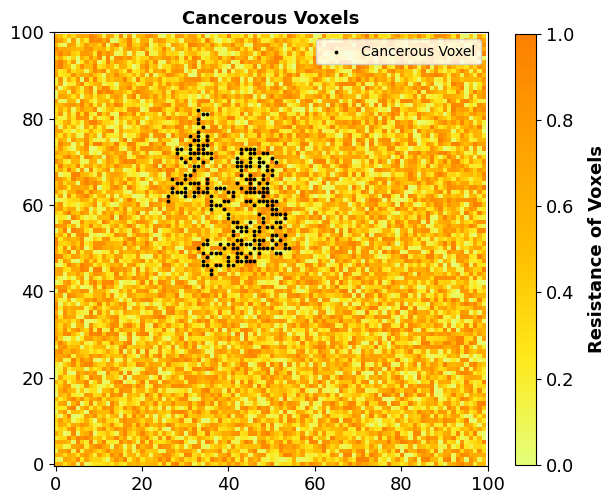

In [6]:
grid_size = 100
resistance = np.random.rand(grid_size, grid_size) # Create grid with random resistance values

tumor_mask = pd.read_csv("tumor_mask.csv").to_numpy()
plot_tumor_growth(resistance, grid_size, tumor_mask, title=f"Cancerous Voxels", color_bar=True)

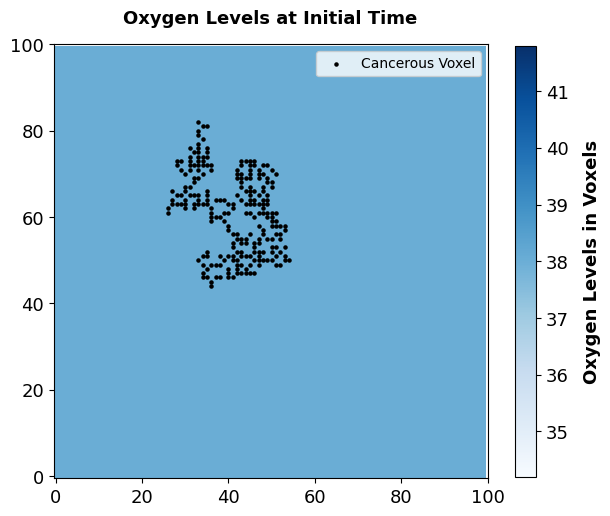

In [7]:
oxygen = np.full((grid_size, grid_size), 38.0)  # mmHg everywhere
plot_oxygen_diffusion(oxygen, grid_size, tumor_mask, f"Oxygen Levels at Initial Time", tumor_flag=True)


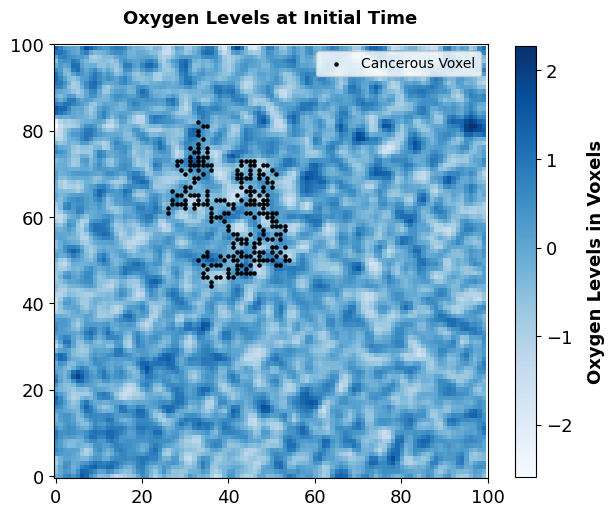

In [8]:
# Add physiological noise
np.random.seed(42)
noise_strength = 2.0  # mmHg, strength of physiological fluctuation
noise = np.random.normal(loc=0.0, scale=noise_strength, size=(grid_size, grid_size))
noise = gaussian_filter(noise, sigma=1.0)  # smooth the noise for realism
plot_oxygen_diffusion(noise, grid_size, tumor_mask, f"Oxygen Levels at Initial Time", tumor_flag=True)


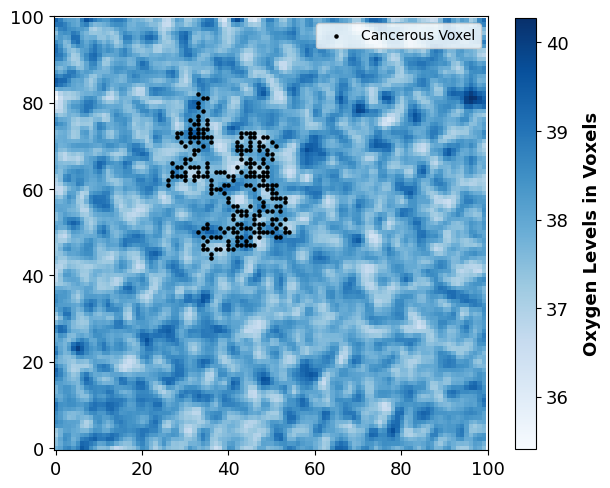

In [9]:
substrate = oxygen + noise
plot_oxygen_diffusion(substrate, grid_size, tumor_mask, "", tumor_flag=True)

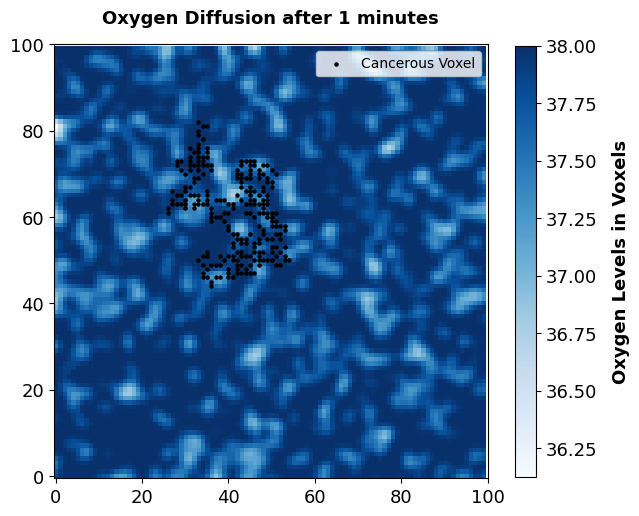

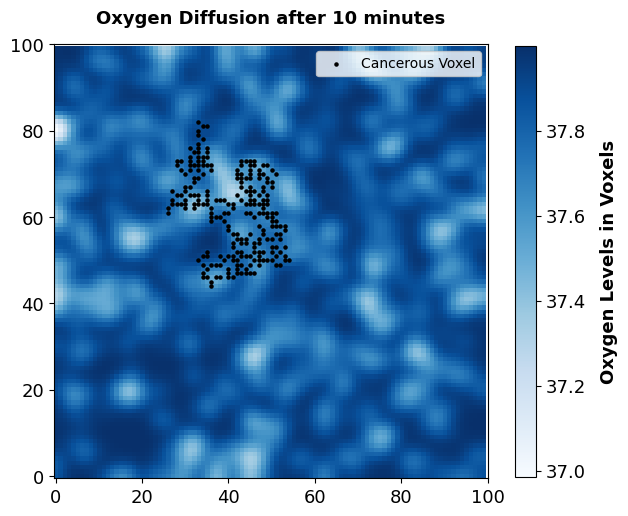

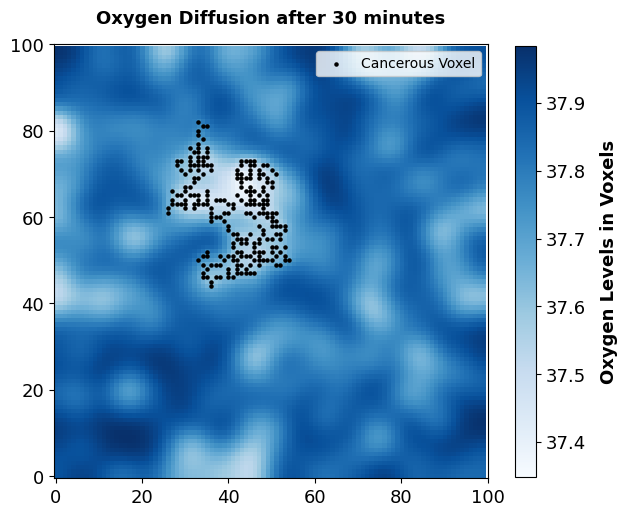

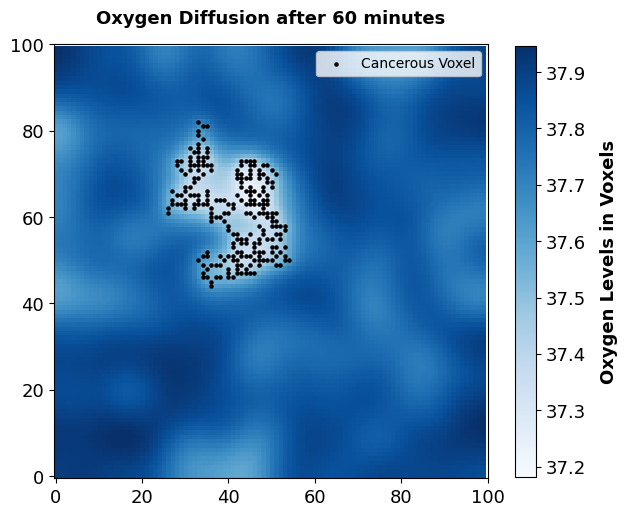

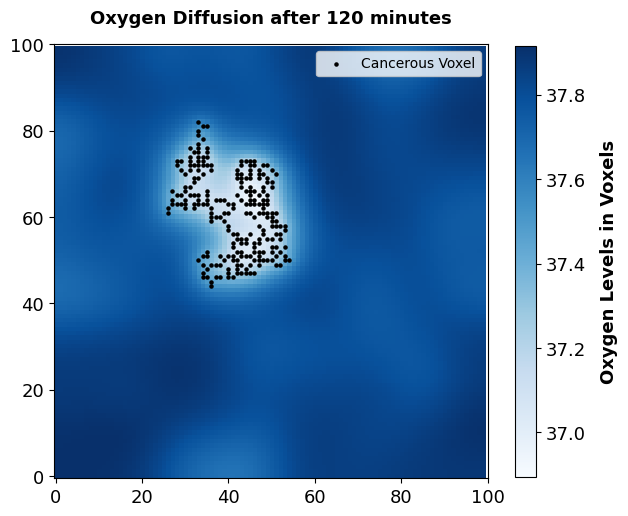

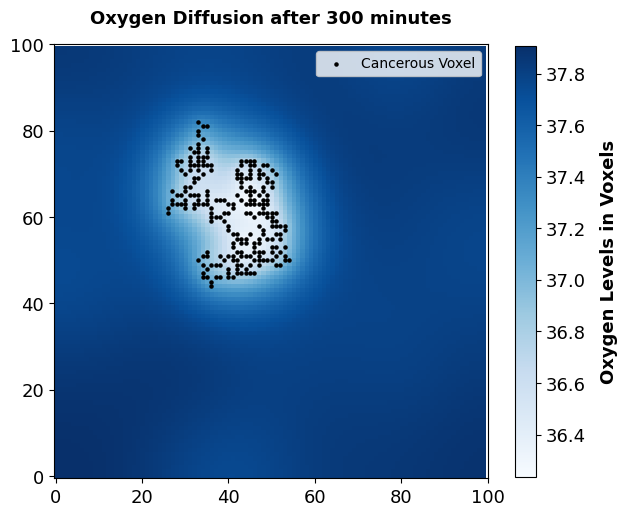

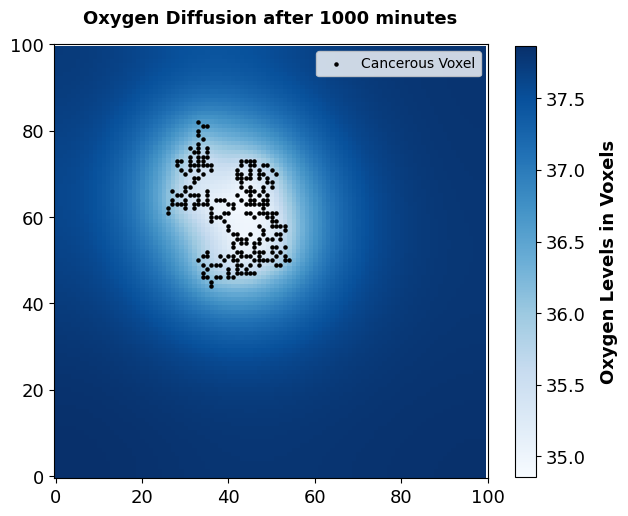

In [10]:
# --- Simulation Parameters (based on PhysiCell) ---
dx = 100.0                   # μm per voxel (100 µm)
dt = 0.01                    # minutes
D  = 2e5                     # diffusion coefficient in μm²/min (same as 2e-5 cm²/s)
lambda_decay = 0.05          # oxygen uptake rate in min⁻¹
time_steps = 1000

for t in range(time_steps):
    directions = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]

    # Environmental Dynamics
    laplacian = laplace(substrate, mode='reflect')       # Laplacian using scipy.ndimage
    diffusion_term = D * laplacian / dx**2
    decay_term = -lambda_decay * substrate * tumor_mask  # Decay only in tumor voxels
    substrate += dt * (diffusion_term + decay_term)      # Explicit update
    substrate = np.clip(substrate, 0, 38.0)                 # clamp to physical range

    snapshots = [1, 10, 30, 60, 120, 300, 1200, 5000, 10000]
    if t in snapshots:
        plot_oxygen_diffusion(substrate, grid_size, tumor_mask, f"Oxygen Diffusion after {t} minutes", tumor_flag=True)
        # plot_oxygen_diffusion(oxygen, grid_size, tumor_mask, "", tumor_flag=True)

plot_oxygen_diffusion(substrate, grid_size, tumor_mask, f"Oxygen Diffusion after {time_steps} minutes", tumor_flag=True)


In [11]:
import csv

with open('oxygen_single_tumor.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for row in substrate:
      writer.writerow(row)

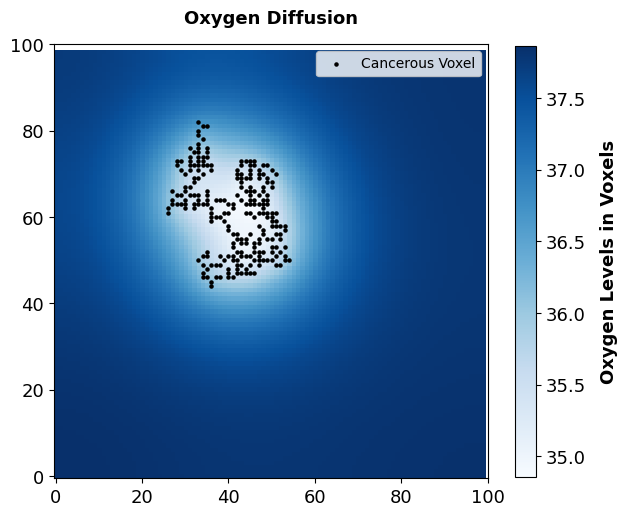

In [13]:
import pandas as pd

substrate = pd.read_csv("oxygen_single_tumor.csv").to_numpy()
plot_oxygen_diffusion(substrate, grid_size, tumor_mask, f"Oxygen Diffusion", tumor_flag=True)
